## Deep Learning Course Project - Gesture Recognition

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [ ]:
# Supress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [ ]:
## Checking the GPU configuration

!nvidia-smi

Mon Feb  8 12:44:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.30                 Driver Version: 390.30                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    70W / 149W |      0MiB / 11441MiB |     95%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import cv2

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30) # not working
# tf.random.set_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 20     #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
SHOW_DEBUG_STEP=False

In [ ]:
def generator(source_path, folder_list, batch_size,mode):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [ 0,  2,  3,  5,  7,  9, 10, 12, 14, 15, 17, 19, 20, 22, 24, 26, 27, 29]   #create a list of image numbers you want to use for a particular video
    #################
    x=len(img_idx)
    y=120
    z=120
    ################
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size              # calculate the number of batches
        remaining_seq=len(t)%batch_size
       
        for batch in range(num_batches): # we iterate over the number of batches
            if SHOW_DEBUG_STEP:
                print("batch number ",str(batch))
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            if mode=='train':
                batch_data_aug = np.zeros((batch_size,x,y,z,3))
                if SHOW_DEBUG_STEP:
                        print("imge data aug container created ")
                
                
          
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized=imresize(image,(y,z,3))
            
                #normalizing the images
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                    if mode=='train':
                        shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                        cropped=shifted[x0:x1,y0:y1,:]
                    
                        image_resized=imresize(cropped,(y,z,3))
                   
            
                        batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                        if SHOW_DEBUG_STEP:
                            print("cropping and resizing done!!")
                        
                
#                 if mode=='train':
#                     batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                    
            
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 
            
            if mode=='train':
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
                if SHOW_DEBUG_STEP:
                    print("Aug leabel and imgss added  ")
                    

                
            if SHOW_DEBUG_STEP:
                print("batch data "+str(batch_data.shape)+" "+str(batch_labels.shape))
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


            
        # write the code for the remaining data points which are left after full batches
        if remaining_seq != 0:
            if SHOW_DEBUG_STEP:
                print("sequence ")
            batch_data = np.zeros((remaining_seq,x,y,z,3))
            batch_labels = np.zeros((remaining_seq,5))
            if mode=='train':
                batch_data_aug = np.zeros((remaining_seq,x,y,z,3))
          
            for folder in range(remaining_seq):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized=imresize(image,(y,z,3))
            
                #normalizing the images
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                    if mode=='train':
                        shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                        cropped=shifted[x0:x1,y0:y1,:]
                    
                        image_resized=imresize(cropped,(y,z,3))
                   
            
                        batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 
            if mode=='train':
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
                    

                
            if SHOW_DEBUG_STEP:
                print("batch data "+str(batch_data.shape)+" "+str(batch_labels.shape))               
            yield batch_data, batch_labels




Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =  35 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 35


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D,MaxPooling2D,Conv2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras import optimizers
from keras.applications import MobileNetV2

## CNN - LSTM Model

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv2D(18, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(18,120,120,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model.add(TimeDistributed(Flatten()))


model.add(LSTM(128))
model.add(Dropout(0.4))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser  = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 18, 120, 120, 18)  504       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 120, 120, 18)  72        
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 60, 60, 18)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 60, 60, 32)    5216      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 18, 30, 30, 64)    18496     
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,mode='train')
val_generator = generator(val_path, val_doc, batch_size,mode='val')

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
ES = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)

callbacks_list = [checkpoint, LR,ES]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### Code for Plotting the Loss and accuracy 

In [ ]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1)

Source path =  ./Project_data/val ; batch size = 20
Source path =  ./Project_data/train ; batch size = 20
Epoch 1/35
34/34 [==============================] - 243s 7s/step - loss: 1.5421 - categorical_accuracy: 0.3046 - val_loss: 1.4360 - val_categorical_accuracy: 0.3500

Epoch 00001: val_loss improved from inf to 1.43599, saving model to model_init_2021-02-0812_46_24.056165/model-00001-1.52876-0.31222-1.43599-0.35000.h5
Epoch 2/35
34/34 [==============================] - 94s 3s/step - loss: 1.3160 - categorical_accuracy: 0.4334 - val_loss: 1.1834 - val_categorical_accuracy: 0.5000

Epoch 00002: val_loss improved from 1.43599 to 1.18344, saving model to model_init_2021-02-0812_46_24.056165/model-00002-1.30359-0.43590-1.18344-0.50000.h5
Epoch 3/35
34/34 [==============================] - 93s 3s/step - loss: 1.2430 - categorical_accuracy: 0.4731 - val_loss: 1.0618 - val_categorical_accuracy: 0.5200

Epoch 00003: val_loss improved from 1.18344 to 1.06176, saving model to model_init_2021-02


Epoch 00031: val_loss did not improve from 0.49450
Epoch 32/35
34/34 [==============================] - 94s 3s/step - loss: 0.3633 - categorical_accuracy: 0.9051 - val_loss: 0.4773 - val_categorical_accuracy: 0.8200

Epoch 00032: val_loss improved from 0.49450 to 0.47730, saving model to model_init_2021-02-0812_46_24.056165/model-00032-0.23995-0.92760-0.47730-0.82000.h5
Epoch 33/35
34/34 [==============================] - 93s 3s/step - loss: 0.2680 - categorical_accuracy: 0.9202 - val_loss: 0.4995 - val_categorical_accuracy: 0.7900

Epoch 00033: val_loss did not improve from 0.47730
Epoch 34/35
34/34 [==============================] - 93s 3s/step - loss: 0.3089 - categorical_accuracy: 0.9191 - val_loss: 0.5218 - val_categorical_accuracy: 0.7900

Epoch 00034: val_loss did not improve from 0.47730
Epoch 35/35
34/34 [==============================] - 96s 3s/step - loss: 0.2773 - categorical_accuracy: 0.9117 - val_loss: 0.5249 - val_categorical_accuracy: 0.8000

Epoch 00035: val_loss did 

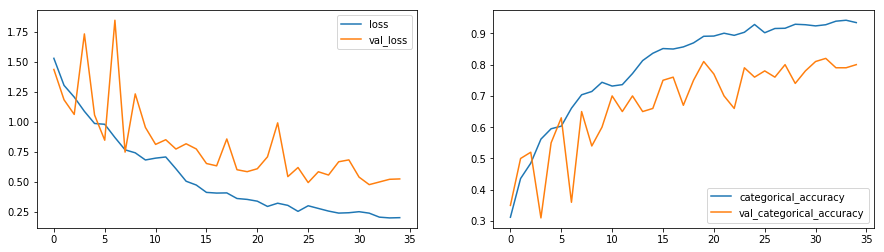

In [ ]:
plot(history)

#### For ``CNN - LSTM`` model we get a best training 90% and validation accuracy 82%

![final%20model.jpg](attachment:final%20model.jpg)